## Predicting Readmission with Discharge Summaries
## 퇴원노트로 재입원 예측하기

This notebook is studying purpose following Andrew Long's Introduction to Clinical Natural Language Processing: https://github.com/andrewwlong/mimic_bow/blob/master/mimic_bow_full.ipynb

I've applied some changes for more exploration purposes.
- **I've used all multi-notes for each admission for prediction model**

### model 
: predict which patients are at risk for 30-day unplanned readmission with discharge summary notes

### Dataset
: MIMIC-III
- 1) ADMISSIONS : table containing admission and discharge dates
- 2) NOTEEVENTS : notes for each hospitalization
- HADM_ID

## Preprocessing:

### 1. ADMISSION
- retreive data from admission (admission_type only {urgent or emergency or elective})
- convert strings to dates
- get the next unplanned admission
- calculate days until next admission

### 2. NOTES
- filter discharge summaries
- concatenate all notes with same subject_id and hadm_id

### 3. MERGE
- merge admission and notes
- label output
- make training/validation/test set (sub-sample)

### 4. Preprocess text data

### 1. ADMISSION

#### 1.1
- retreive admission data with admission_type **{elective or emergency or urgent}** 
- **{admittime, dischtime, deathtime}** will be converted to timestamp if applicable.  
(format YYYY-MM-DD hh:mm:ss)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import datetime

sys.path.append('./db')

import alchemy_con
engine = alchemy_con.get_engine()

In [2]:
df_adm = pd.read_sql("""SELECT subject_id, hadm_id, admittime, dischtime, deathtime, admission_type, edregtime, edouttime, diagnosis
                        FROM ADMISSIONS
                        WHERE admission_type in ('ELECTIVE', 'EMERGENCY', 'URGENT')
                        ;""", engine)
df_adm.head()
df_adm.to_csv('./resource/admissions_no_newborn.csv', sep=',')

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,edregtime,edouttime,diagnosis
0,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaT,EMERGENCY,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE
1,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaT,ELECTIVE,NaT,NaT,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...
2,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaT,EMERGENCY,NaT,NaT,BRAIN MASS
3,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaT,EMERGENCY,NaT,NaT,INTERIOR MYOCARDIAL INFARCTION
4,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaT,EMERGENCY,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME


In [3]:
df_adm.shape

(51113, 9)

#### check data type for admittime and dischtime

In [4]:
df_adm.admittime.dtype

dtype('<M8[ns]')

In [5]:
df_adm.admittime[0]

Timestamp('2196-04-09 12:26:00')

#### for deathtime, convert to timestamp

In [6]:
# coerce to allow for missing dates
df_adm.deathtime = pd.to_datetime(df_adm.deathtime, \
                                  format='%Y-%m-%d %H:%M:%S', \
                                  errors='coerce')

In [7]:
df_adm.deathtime.dtype

dtype('<M8[ns]')

In [8]:
df_adm.deathtime[0]

NaT

In [9]:
# columns
df_adm.columns

Index(['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime',
       'admission_type', 'edregtime', 'edouttime', 'diagnosis'],
      dtype='object')

#### columns
- https://mimic.physionet.org/mimictables/admissions/

subject_id  
hadm_id : hospitalization id  
admittime : format YYYY-MM-DD hh:mm:ss  
dischtime :  
deathtime : if exists  
admission_type : elective, emergency, newborn, urgent  
edregtime : time registered for Emergency department  
edouttime : time discharged from Emergency department  
  
due to de-dientification, date can be assigned to future.

In [10]:
# admission type
df_adm.groupby(df_adm.admission_type).size()

admission_type
ELECTIVE      7706
EMERGENCY    42071
URGENT        1336
dtype: int64

#### 1.2 get the next unplanned admission date if exists

In [11]:
# sort subject_id and admission date
df_adm.sort_values(['subject_id', 'admittime'], inplace=True)
df_adm.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,edregtime,edouttime,diagnosis
179,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaT,EMERGENCY,2101-10-20 17:09:00,2101-10-20 19:24:00,HYPOTENSION
180,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaT,EMERGENCY,2191-03-15 13:10:00,2191-03-16 01:10:00,"FEVER,DEHYDRATION,FAILURE TO THRIVE"
181,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaT,ELECTIVE,NaT,NaT,CHRONIC RENAL FAILURE/SDA
182,9,150750,2149-11-09 13:06:00,2149-11-14 10:15:00,2149-11-14 10:15:00,EMERGENCY,2149-11-09 11:13:00,2149-11-09 13:18:00,HEMORRHAGIC CVA
183,11,194540,2178-04-16 06:18:00,2178-05-11 19:00:00,NaT,EMERGENCY,2178-04-15 20:46:00,2178-04-16 06:53:00,BRAIN MASS


In [12]:
# find patients with multiple records
df_adm.groupby([df_adm.subject_id, df_adm.admission_type]).size()[df_adm.groupby([df_adm.subject_id, df_adm.admission_type]).size() > 15]


subject_id  admission_type
109         EMERGENCY         34
4787        EMERGENCY         16
5060        EMERGENCY         31
5727        EMERGENCY         21
7275        EMERGENCY         16
7809        EMERGENCY         22
11318       EMERGENCY         18
11861       EMERGENCY         34
13033       EMERGENCY         42
19059       EMERGENCY         17
19213       EMERGENCY         23
20643       EMERGENCY         24
23657       EMERGENCY         20
23707       EMERGENCY         17
73713       EMERGENCY         17
dtype: int64

In [13]:
# check for a single patient
df_adm.loc[df_adm.subject_id==4787]

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,edregtime,edouttime,diagnosis
5056,4787,135251,2123-05-29 05:52:00,2123-06-04 16:55:00,NaT,EMERGENCY,2123-05-29 00:24:00,2123-05-29 05:53:00,SEPSIS
5057,4787,109022,2123-06-11 18:53:00,2123-06-23 18:19:00,NaT,EMERGENCY,2123-06-11 10:15:00,2123-06-11 21:50:00,RENAL STONE
5058,4787,104141,2123-12-16 00:07:00,2123-12-18 14:29:00,NaT,EMERGENCY,2123-12-15 20:58:00,2123-12-16 01:13:00,SEPSIS
5482,4787,120913,2124-01-12 14:35:00,2124-01-17 14:15:00,NaT,EMERGENCY,2124-01-12 09:55:00,2124-01-12 16:04:00,LOWER GI BLEED
5483,4787,112190,2124-10-24 17:21:00,2124-10-30 13:23:00,NaT,EMERGENCY,2124-10-24 01:33:00,2124-10-24 17:54:00,CONGESTIVE HEART FAILURE
5484,4787,165271,2125-09-06 16:05:00,2125-09-17 17:45:00,NaT,EMERGENCY,2125-09-06 13:26:00,2125-09-06 17:42:00,HYPOTENSION
5485,4787,189443,2125-10-16 17:21:00,2125-10-23 14:27:00,NaT,EMERGENCY,2125-10-16 12:06:00,2125-10-16 18:06:00,SEPSIS
5486,4787,123124,2125-12-01 16:43:00,2125-12-12 16:54:00,NaT,EMERGENCY,2125-12-01 12:29:00,2125-12-01 17:34:00,FEVER/HYPOTENSION
5487,4787,135926,2126-01-21 23:13:00,2126-01-26 16:20:00,NaT,EMERGENCY,2126-01-21 20:16:00,2126-01-22 00:31:00,SEPSIS
5488,4787,114129,2126-06-30 02:01:00,2126-07-09 18:00:00,NaT,EMERGENCY,2126-06-29 21:45:00,2126-06-30 02:29:00,SEPSIS


In [14]:
# use groupby and shift to add the next admission date for each subject
df_adm['next_admittime'] = df_adm.groupby(df_adm.subject_id).admittime.shift(-1)
df_adm.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,edregtime,edouttime,diagnosis,next_admittime
179,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaT,EMERGENCY,2101-10-20 17:09:00,2101-10-20 19:24:00,HYPOTENSION,NaT
180,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaT,EMERGENCY,2191-03-15 13:10:00,2191-03-16 01:10:00,"FEVER,DEHYDRATION,FAILURE TO THRIVE",NaT
181,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaT,ELECTIVE,NaT,NaT,CHRONIC RENAL FAILURE/SDA,NaT
182,9,150750,2149-11-09 13:06:00,2149-11-14 10:15:00,2149-11-14 10:15:00,EMERGENCY,2149-11-09 11:13:00,2149-11-09 13:18:00,HEMORRHAGIC CVA,NaT
183,11,194540,2178-04-16 06:18:00,2178-05-11 19:00:00,NaT,EMERGENCY,2178-04-15 20:46:00,2178-04-16 06:53:00,BRAIN MASS,NaT


In [15]:
# get next admission type
df_adm['next_admission_type'] =df_adm.groupby(df_adm.subject_id).admission_type.shift(-1)
df_adm.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,edregtime,edouttime,diagnosis,next_admittime,next_admission_type
179,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaT,EMERGENCY,2101-10-20 17:09:00,2101-10-20 19:24:00,HYPOTENSION,NaT,NaN
180,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaT,EMERGENCY,2191-03-15 13:10:00,2191-03-16 01:10:00,"FEVER,DEHYDRATION,FAILURE TO THRIVE",NaT,NaN
181,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaT,ELECTIVE,NaT,NaT,CHRONIC RENAL FAILURE/SDA,NaT,NaN
182,9,150750,2149-11-09 13:06:00,2149-11-14 10:15:00,2149-11-14 10:15:00,EMERGENCY,2149-11-09 11:13:00,2149-11-09 13:18:00,HEMORRHAGIC CVA,NaT,NaN
183,11,194540,2178-04-16 06:18:00,2178-05-11 19:00:00,NaT,EMERGENCY,2178-04-15 20:46:00,2178-04-16 06:53:00,BRAIN MASS,NaT,NaN


In [16]:
df_adm.loc[df_adm.subject_id==4787]

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,edregtime,edouttime,diagnosis,next_admittime,next_admission_type
5056,4787,135251,2123-05-29 05:52:00,2123-06-04 16:55:00,NaT,EMERGENCY,2123-05-29 00:24:00,2123-05-29 05:53:00,SEPSIS,2123-06-11 18:53:00,EMERGENCY
5057,4787,109022,2123-06-11 18:53:00,2123-06-23 18:19:00,NaT,EMERGENCY,2123-06-11 10:15:00,2123-06-11 21:50:00,RENAL STONE,2123-12-16 00:07:00,EMERGENCY
5058,4787,104141,2123-12-16 00:07:00,2123-12-18 14:29:00,NaT,EMERGENCY,2123-12-15 20:58:00,2123-12-16 01:13:00,SEPSIS,2124-01-12 14:35:00,EMERGENCY
5482,4787,120913,2124-01-12 14:35:00,2124-01-17 14:15:00,NaT,EMERGENCY,2124-01-12 09:55:00,2124-01-12 16:04:00,LOWER GI BLEED,2124-10-24 17:21:00,EMERGENCY
5483,4787,112190,2124-10-24 17:21:00,2124-10-30 13:23:00,NaT,EMERGENCY,2124-10-24 01:33:00,2124-10-24 17:54:00,CONGESTIVE HEART FAILURE,2125-09-06 16:05:00,EMERGENCY
5484,4787,165271,2125-09-06 16:05:00,2125-09-17 17:45:00,NaT,EMERGENCY,2125-09-06 13:26:00,2125-09-06 17:42:00,HYPOTENSION,2125-10-16 17:21:00,EMERGENCY
5485,4787,189443,2125-10-16 17:21:00,2125-10-23 14:27:00,NaT,EMERGENCY,2125-10-16 12:06:00,2125-10-16 18:06:00,SEPSIS,2125-12-01 16:43:00,EMERGENCY
5486,4787,123124,2125-12-01 16:43:00,2125-12-12 16:54:00,NaT,EMERGENCY,2125-12-01 12:29:00,2125-12-01 17:34:00,FEVER/HYPOTENSION,2126-01-21 23:13:00,EMERGENCY
5487,4787,135926,2126-01-21 23:13:00,2126-01-26 16:20:00,NaT,EMERGENCY,2126-01-21 20:16:00,2126-01-22 00:31:00,SEPSIS,2126-06-30 02:01:00,EMERGENCY
5488,4787,114129,2126-06-30 02:01:00,2126-07-09 18:00:00,NaT,EMERGENCY,2126-06-29 21:45:00,2126-06-30 02:29:00,SEPSIS,2127-06-07 22:07:00,EMERGENCY


### since the purpose of analysis to predict unplanned re-admission, filter out the elective next admission

In [17]:
# find sample data
df_adm.loc[df_adm.admission_type=='ELECTIVE'].groupby([df_adm.subject_id, df_adm.admission_type]).size()[df_adm.groupby([df_adm.subject_id, df_adm.admission_type]).size() > 4]

subject_id  admission_type
3417        ELECTIVE          5
dtype: int64

In [18]:
df_adm.loc[df_adm.subject_id==3417]

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,edregtime,edouttime,diagnosis,next_admittime,next_admission_type
3405,3417,101256,2153-06-14 22:49:00,2153-07-24 17:05:00,NaT,EMERGENCY,2153-06-14 22:28:00,2153-06-14 23:21:00,DISSECTING THORACIC ANEURYSM,2154-03-19 14:00:00,ELECTIVE
3406,3417,192392,2154-03-19 14:00:00,2154-04-09 17:15:00,NaT,ELECTIVE,NaT,NaT,DEEP VEIN THROMBOSIS/ S/P AVR\ REDO HEMI STREN...,2154-12-06 03:22:00,EMERGENCY
3407,3417,123828,2154-12-06 03:22:00,2154-12-24 15:30:00,NaT,EMERGENCY,2154-12-06 01:03:00,2154-12-06 03:10:00,BOORHAAVE'S,2155-07-09 08:00:00,ELECTIVE
3408,3417,164370,2155-07-09 08:00:00,2155-07-18 13:00:00,NaT,ELECTIVE,NaT,NaT,ABDOMINAL AORTIC ANEURYSM/SDA,2155-09-10 08:00:00,ELECTIVE
3409,3417,168644,2155-09-10 08:00:00,2155-09-14 12:20:00,NaT,ELECTIVE,NaT,NaT,THORACIC ANEURYSM/SDA,2155-10-21 07:15:00,ELECTIVE
3410,3417,192539,2155-10-21 07:15:00,2155-10-29 14:50:00,NaT,ELECTIVE,NaT,NaT,DIAPHRAGMATIC HERNIA/SDA,2156-01-07 08:00:00,ELECTIVE
3411,3417,198281,2156-01-07 08:00:00,2156-01-09 13:30:00,NaT,ELECTIVE,NaT,NaT,ABDOMINAL AORTIC ANEURYSM/SDA,NaT,NaN


In [19]:
# if next_admission_type == 'ELECTIVE', replace with nan
df_adm.loc[df_adm.next_admission_type=='ELECTIVE', 'next_admittime'] = pd.NaT
df_adm.loc[df_adm.next_admission_type=='ELECTIVE', 'next_admission_type'] = np.NaN

In [20]:
df_adm.loc[df_adm.subject_id==3417]

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,edregtime,edouttime,diagnosis,next_admittime,next_admission_type
3405,3417,101256,2153-06-14 22:49:00,2153-07-24 17:05:00,NaT,EMERGENCY,2153-06-14 22:28:00,2153-06-14 23:21:00,DISSECTING THORACIC ANEURYSM,NaT,NaN
3406,3417,192392,2154-03-19 14:00:00,2154-04-09 17:15:00,NaT,ELECTIVE,NaT,NaT,DEEP VEIN THROMBOSIS/ S/P AVR\ REDO HEMI STREN...,2154-12-06 03:22:00,EMERGENCY
3407,3417,123828,2154-12-06 03:22:00,2154-12-24 15:30:00,NaT,EMERGENCY,2154-12-06 01:03:00,2154-12-06 03:10:00,BOORHAAVE'S,NaT,NaN
3408,3417,164370,2155-07-09 08:00:00,2155-07-18 13:00:00,NaT,ELECTIVE,NaT,NaT,ABDOMINAL AORTIC ANEURYSM/SDA,NaT,NaN
3409,3417,168644,2155-09-10 08:00:00,2155-09-14 12:20:00,NaT,ELECTIVE,NaT,NaT,THORACIC ANEURYSM/SDA,NaT,NaN
3410,3417,192539,2155-10-21 07:15:00,2155-10-29 14:50:00,NaT,ELECTIVE,NaT,NaT,DIAPHRAGMATIC HERNIA/SDA,NaT,NaN
3411,3417,198281,2156-01-07 08:00:00,2156-01-09 13:30:00,NaT,ELECTIVE,NaT,NaT,ABDOMINAL AORTIC ANEURYSM/SDA,NaT,NaN


### backfill nan, naT data above -> 

- emergency -> emergency or urgent
- elective -> emergency or urgent
- urgent -> emergency or urgent  
we are considering all above cases regardless of elective admission in between

In [21]:
# sort again in case something changed the order
df_adm.sort_values(['subject_id', 'admittime'], inplace=True)

In [22]:
# backfill
df_adm[['next_admittime', 'next_admission_type']] = df_adm.groupby(df_adm.subject_id)[['next_admittime', 'next_admission_type']].fillna(method='bfill')

In [23]:
df_adm.loc[df_adm.subject_id==3417]

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,edregtime,edouttime,diagnosis,next_admittime,next_admission_type
3405,3417,101256,2153-06-14 22:49:00,2153-07-24 17:05:00,NaT,EMERGENCY,2153-06-14 22:28:00,2153-06-14 23:21:00,DISSECTING THORACIC ANEURYSM,2154-12-06 03:22:00,EMERGENCY
3406,3417,192392,2154-03-19 14:00:00,2154-04-09 17:15:00,NaT,ELECTIVE,NaT,NaT,DEEP VEIN THROMBOSIS/ S/P AVR\ REDO HEMI STREN...,2154-12-06 03:22:00,EMERGENCY
3407,3417,123828,2154-12-06 03:22:00,2154-12-24 15:30:00,NaT,EMERGENCY,2154-12-06 01:03:00,2154-12-06 03:10:00,BOORHAAVE'S,NaT,NaN
3408,3417,164370,2155-07-09 08:00:00,2155-07-18 13:00:00,NaT,ELECTIVE,NaT,NaT,ABDOMINAL AORTIC ANEURYSM/SDA,NaT,NaN
3409,3417,168644,2155-09-10 08:00:00,2155-09-14 12:20:00,NaT,ELECTIVE,NaT,NaT,THORACIC ANEURYSM/SDA,NaT,NaN
3410,3417,192539,2155-10-21 07:15:00,2155-10-29 14:50:00,NaT,ELECTIVE,NaT,NaT,DIAPHRAGMATIC HERNIA/SDA,NaT,NaN
3411,3417,198281,2156-01-07 08:00:00,2156-01-09 13:30:00,NaT,ELECTIVE,NaT,NaT,ABDOMINAL AORTIC ANEURYSM/SDA,NaT,NaN


### calculate the days until the next admission

In [24]:
df_adm['days_until_next_adm'] =\
(df_adm.next_admittime - df_adm.dischtime).dt.total_seconds()/(24*60*60)

In [25]:
df_adm.loc[df_adm.subject_id==3417]

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,edregtime,edouttime,diagnosis,next_admittime,next_admission_type,days_until_next_adm
3405,3417,101256,2153-06-14 22:49:00,2153-07-24 17:05:00,NaT,EMERGENCY,2153-06-14 22:28:00,2153-06-14 23:21:00,DISSECTING THORACIC ANEURYSM,2154-12-06 03:22:00,EMERGENCY,499.428472
3406,3417,192392,2154-03-19 14:00:00,2154-04-09 17:15:00,NaT,ELECTIVE,NaT,NaT,DEEP VEIN THROMBOSIS/ S/P AVR\ REDO HEMI STREN...,2154-12-06 03:22:00,EMERGENCY,240.421528
3407,3417,123828,2154-12-06 03:22:00,2154-12-24 15:30:00,NaT,EMERGENCY,2154-12-06 01:03:00,2154-12-06 03:10:00,BOORHAAVE'S,NaT,NaN,NaN
3408,3417,164370,2155-07-09 08:00:00,2155-07-18 13:00:00,NaT,ELECTIVE,NaT,NaT,ABDOMINAL AORTIC ANEURYSM/SDA,NaT,NaN,NaN
3409,3417,168644,2155-09-10 08:00:00,2155-09-14 12:20:00,NaT,ELECTIVE,NaT,NaT,THORACIC ANEURYSM/SDA,NaT,NaN,NaN
3410,3417,192539,2155-10-21 07:15:00,2155-10-29 14:50:00,NaT,ELECTIVE,NaT,NaT,DIAPHRAGMATIC HERNIA/SDA,NaT,NaN,NaN
3411,3417,198281,2156-01-07 08:00:00,2156-01-09 13:30:00,NaT,ELECTIVE,NaT,NaT,ABDOMINAL AORTIC ANEURYSM/SDA,NaT,NaN,NaN


(array([2992., 1216.,  743.,  499.,  415.,  376.,  292.,  269.,  202.,
         191.,  204.,  191.]),
 array([  0,  30,  60,  90, 120, 150, 180, 210, 240, 270, 300, 330, 360]),
 <a list of 12 Patch objects>)

Text(0.5,0,'days between admissions')

Text(0,0.5,'counts')

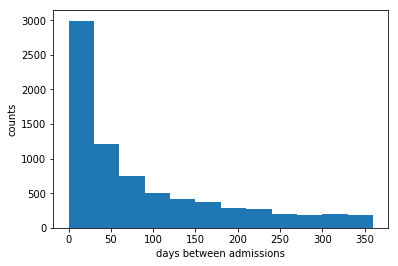

In [26]:
# histogram with non-null values
plt.hist(df_adm.loc[~df_adm.days_until_next_adm.isnull(), \
                    'days_until_next_adm'],\
                   bins=range(0, 365, 30))

plt.xlabel('days between admissions')
plt.ylabel('counts')
plt.show()

#### number with a readmission

In [27]:
(~df_adm.days_until_next_adm.isnull()).sum()

11169

### 2. NOTES

In [28]:
note_categories = pd.read_sql("""
                                SELECT DISTINCT(category) FROM noteevents;
                                """, engine)

In [29]:
note_categories

,category
0,Consult
1,Social Work
2,ECG
3,Case Management
4,Nutrition
5,Radiology
6,Discharge summary
7,Pharmacy
8,Respiratory
9,Nursing/other


#### 2.1 filter discharge summaries

In [30]:
# for this practice, use discharge summary only
df_notes = pd.read_sql("""SELECT * FROM noteevents WHERE category='Discharge summary';""", engine)

In [31]:
df_notes.head()
df_notes.to_csv('./resource/discharge_summary.csv', sep=',')

,row_id,subject_id,hadm_id,chartdate,charttime,storetime,category,description,cgid,iserror,text
0,174,22532,167853,2151-08-04,None,None,Discharge summary,Report,None,None,Admission Date: [**2151-7-16**] Dischar...
1,175,13702,107527,2118-06-14,None,None,Discharge summary,Report,None,None,Admission Date: [**2118-6-2**] Discharg...
2,176,13702,167118,2119-05-25,None,None,Discharge summary,Report,None,None,Admission Date: [**2119-5-4**] D...
3,177,13702,196489,2124-08-18,None,None,Discharge summary,Report,None,None,Admission Date: [**2124-7-21**] ...
4,178,26880,135453,2162-03-25,None,None,Discharge summary,Report,None,None,Admission Date: [**2162-3-3**] D...


In [32]:
df_notes.chartdate.dtype

dtype('<M8[ns]')

### columns

- subject_id
- hadm_id
- category
- text

**there can be multiple notes per hospitalization.**

In [33]:
df_notes.sort_values(['subject_id', 'chartdate'], inplace=True)

In [34]:
df_notes.duplicated('hadm_id').sum()

6926

In [35]:
# checking multiple notes
df_notes.text.groupby([df_notes.subject_id, df_notes.hadm_id]).size()

subject_id  hadm_id
3           145834     1
4           185777     1
6           107064     1
9           150750     2
10          184167     1
11          194540     1
12          112213     1
13          143045     2
17          161087     1
            194023     1
18          188822     3
19          109235     1
20          157681     2
21          109451     1
            111970     1
22          165315     1
23          124321     1
            152223     1
24          161859     1
25          129635     1
26          197661     1
28          162569     1
30          104557     1
31          128652     1
32          175413     1
33          176176     1
34          144319     1
35          166707     1
36          122659     1
            165660     1
                      ..
99899       188409     1
99901       131711     1
99903       135939     1
99912       189380     1
99913       175989     1
99922       123563     1
99923       164914     1
            192053     1
99928

#### 2. 2 concatenate all notes with same subject_id and hadm_id

In [36]:
# combine all text with same subject_id and hadm_id
df_notes_ = df_notes.groupby(['subject_id','hadm_id'])['text'].apply('\n'.join).reset_index()
df_notes_.head()

,subject_id,hadm_id,text
0,3,145834,Admission Date: [**2101-10-20**] Discharg...
1,4,185777,Admission Date: [**2191-3-16**] Discharge...
2,6,107064,Admission Date: [**2175-5-30**] Dischar...
3,9,150750,Admission Date: [**2149-11-9**] Dischar...
4,10,184167,Admission Date: [**2103-6-28**] Dischar...


In [37]:
# sample data to check aggregation of text is valid
df_notes[df_notes.subject_id == 9].text

22283    Admission Date:  [**2149-11-9**]       Dischar...
56854    Name:  [**Known lastname 10050**], [**Known fi...
Name: text, dtype: object

In [38]:
df_notes_[df_notes_.subject_id == 9].text.values[0]

"Admission Date:  [**2149-11-9**]       Discharge Date: [**2149-11-13**]\n\nDate of Birth:   [**2108-1-26**]       Sex:  M\n\nService:  NEUROLOGY\n\nCHIEF COMPLAINT:  Weakness, inability to talk.\n\nHISTORY OF THE PRESENT ILLNESS:  This is a 41-year-old\nAfrican-American male with a history of hypertension who was\nin his usual state of health until about 10:25 a.m. on the\nmorning of admission.  He had gone to use the restroom and a\nfew minutes later his family found him slumped onto the\nfloor, apparently unable to talk and with weakness in his\nright arm and leg.  EMS was called and he was brought into\nthe Emergency Department at [**Hospital1 18**].\n\nThe patient has not had strokes or previous similar symptoms.\nHe has a history of hypertension but no history of cardiac\nsymptoms.  The patient was unable to talk for examination and\nno family members were present at the bedside and were not at\nhome (apparently they were on the way to the Emergency Room).\nThe history was obtain

### 3. MERGE

#### 3.1 merge admission and notes

In [39]:
df_adm_notes = pd.merge(df_adm[['subject_id', 'hadm_id', 'admittime', 'dischtime',\
                               'days_until_next_adm', 'next_admittime', 'admission_type', 'deathtime']],\
                       df_notes_[['subject_id', 'hadm_id', 'text']],\
                       on=['subject_id', 'hadm_id'],
                       how='left')

In [40]:
assert len(df_adm) == len(df_adm_notes), 'number of rows not matched'

#### check missing text

In [41]:
df_adm_notes.text.isnull().sum() / len(df_adm_notes)

0.03971592354195606

In [42]:
df_adm_notes.text.str.contains('\n').sum() / len(df_adm_notes)

0.9602840764580439

In [43]:
df_adm_notes.groupby('admission_type').apply(lambda x: x.text.isnull().sum()) / \
df_adm_notes.groupby('admission_type').size()

admission_type
ELECTIVE     0.048663
EMERGENCY    0.037983
URGENT       0.042665
dtype: float64

### 4. Preprocess text data

Before preprocessing text data, I explored raw data within database to see if there is any pattern I use to remove or retrieve useful information.

- want to remove results of de-identification since it seems irrelevant to patients' outcome.
    patterns : 
        - Admission Date:  [**2151-7-16**]
        - Discharge Date:  [**2151-8-4**]
        - [**First Name8 (NamePattern2) **] [**First Name4 (NamePattern1) 1775**]
        - [**Last Name (NamePattern1) **], M.D.  [**MD Number(1) 1776**]
        - Attending:[**Last Name (NamePattern1) 1561**]
        - Dictated By:[**Hospital 1807**]
        - D:  [**2151-8-5**]  12:11 
        - T:  [**2151-8-5**]  12:21
        - JOB#:  [**Job Number 1808**]
        - [**5-13**]
        - Completed by:[**2119-5-25**]
        
- notes are stored in dictionary format A: infor.
If infor. is not provided, there is no reason to include A.
In order to achieve this, I've replaced (': \n') to (' ')

In [44]:
# remove de-identification information
import re

regex = re.compile(r"([[a-zA-Z*() 0-9-])*]", re.IGNORECASE)
test = df_adm_notes.text.map(lambda x: regex.sub(" ", str(x)).replace('**', ''))

In [45]:
removal_words = ['admission date:', 'discharge date:', 'attending:',\
                'dictated by:', 'd:', 't:', 'job#:', 'completed by:',\
                'date of birth:']

- using Bag-of-words : break up into individual words and count appearance

In [48]:
test.loc[test.str.find('**')>=0].values

array([], dtype=object)

#### 3.2 label output

In [ ]:
# before, used days for days_until_next_adm
df_adm_notes['output_label'] = (df_adm_notes.days_until_next_adm <30).astype('int')
df_adm_notes.head()

In [ ]:
# number of negative samples
len(df_adm_notes.loc[df_adm_notes.output_label==0])

In [ ]:
# number of positive samples
len(df_adm_notes.loc[df_adm_notes.output_label==1])

#### 3.3 make training/validation/test set

- training set
- validation set
- test set

In [ ]:
# shuffle the samples
df_adm_notes = df_adm_notes.sample(n=len(df_adm_notes), \
                                  random_state=0)

In [ ]:
df_adm_notes = df_adm_notes.reset_index(drop=True)

In [ ]:
df_adm_notes.head()

In [ ]:
# saving 30# for validation and test data
df_valid_test = df_adm_notes.sample(frac=0.3, random_state=0)

In [ ]:
df_test = df_valid_test.sample(frac=0.5, random_state=0)
df_valid = df_valid_test.drop(df_test.index)

In [ ]:
print('Test prevalence n= %d : ' % len(df_test), \
      df_test.output_label.sum() / len(df_test))
print('Valid prevalence n= %d : ' % len(df_valid), \
      df_valid.output_label.sum() / len(df_valid))

In [ ]:
# rest ad training data
df_train = df_adm_notes.drop(df_valid_test.index)

In [ ]:
print('Train prevalence n= %d : ' % len(df_train), \
      df_train.output_label.sum() / len(df_train))
print('ALL prevalence n= %d : ' % len(df_adm_notes), \
      df_adm_notes.output_label.sum() / len(df_adm_notes))

### Dataset imbalance

- balance the data by sub-sampling the negatives
- balance the data by over-sampling the positives
- create synthetic data (SMOTE)

In [ ]:
# sub-sample negatives
rows_pos = df_train.output_label==1
df_train_pos = df_train.loc[rows_pos]
df_train_neg = df_train.loc[~rows_pos]

In [ ]:
# merge balanced data
df_train_bal = pd.concat([df_train_pos, \
                          df_train_neg.sample(n=len(df_train_pos), random_state=0)],\
                        axis=0)

In [ ]:
# shuffle
df_train_bal = df_train_bal.sample(n=len(df_train_bal), random_state=0).reset_index(drop=True)

In [ ]:
print('Train prevalence n= %d : ' % len(df_train_bal), \
      df_train_bal.output_label.sum() / len(df_train_bal))

### Dataset imbalance in Deep learning

1. ** class balancing techniques are only necessary when we actually care about the minority classes. **
In practical case, our model will be biased to learn more prevalent class since it has the most data.

2. **If our goal is to get the highest possibel percentage accuracy. It doesn't really make sense to do any balancing since most of our percentage accuracy will come from the classes with more training.**


- https://towardsdatascience.com/handling-imbalanced-datasets-in-deep-learning-f48407a0e758

- weight balancing : alter the weight when computing the loss.  
ex) class_weight = {'buy': 0.75, 'dont_buy':0.25}  
model.fit(X_train, Y_train, class_weight=class_weight)



- focal loss : down-weights the well-classified examples.  
= net effect of putting more training empahsis on that data that is hard to classify.  


- over and under sampling(same as above)